In [1]:
import random
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import warnings
import seaborn as sns
import nltk
warnings.filterwarnings('ignore')
import matplotlib as mpl
%matplotlib inline
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import joblib

In [2]:
header_list = ["review_id", " order_id", "review_score","review_comment_title","review_comment_message","review_creation_date","review_answer_timestamp"]
df = pd.read_csv('C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/reviews.csv',sep = ';',names=header_list)
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,91845d1f2ee1fdb677c769fad86f2109,f30149f4a8882a08895b6a242aa0d612,5,NaN,very good product,2018-06-07 00:00:00,2018-06-08 10:59:20
1,e5636189f943b2589b37f715a3bcae96,f5eda0ded77c1293b04c953138c8331d,4,NaN,NaN,2017-12-24 00:00:00,2017-12-27 13:23:27
2,32247878e34bd6e8d7dbf7b31a4ae0b0,0bf736fd0fd5169d60de3699fcbcf986,1,NaN,Meu produto não foi entregue até o momento!,2018-01-07 00:00:00,2018-01-11 11:03:53
3,14303ce09673466b69c4354628aa5a84,6f0dfb5b5398b271cc6bbd9ee263530e,5,Produto bom,"Produto bom, mas o pegador da tampa é de plást...",2018-08-08 00:00:00,2018-08-08 23:48:48
4,40f2e7bbfda859ba75411743546849b0,3aba44d8e554ab4bb8c09f6f78032ca8,5,NaN,"Produto igual ao anunciado, de excelente quali...",2018-08-18 00:00:00,2018-08-22 12:40:29


In [3]:
df['Total_review_length'] = df['review_comment_message'].str.len()
df.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,Total_review_length
0,91845d1f2ee1fdb677c769fad86f2109,f30149f4a8882a08895b6a242aa0d612,5,NaN,very good product,2018-06-07 00:00:00,2018-06-08 10:59:20,18.0
1,e5636189f943b2589b37f715a3bcae96,f5eda0ded77c1293b04c953138c8331d,4,NaN,NaN,2017-12-24 00:00:00,2017-12-27 13:23:27,NaN
2,32247878e34bd6e8d7dbf7b31a4ae0b0,0bf736fd0fd5169d60de3699fcbcf986,1,NaN,Meu produto não foi entregue até o momento!,2018-01-07 00:00:00,2018-01-11 11:03:53,43.0
3,14303ce09673466b69c4354628aa5a84,6f0dfb5b5398b271cc6bbd9ee263530e,5,Produto bom,"Produto bom, mas o pegador da tampa é de plást...",2018-08-08 00:00:00,2018-08-08 23:48:48,131.0
4,40f2e7bbfda859ba75411743546849b0,3aba44d8e554ab4bb8c09f6f78032ca8,5,NaN,"Produto igual ao anunciado, de excelente quali...",2018-08-18 00:00:00,2018-08-22 12:40:29,79.0


In [4]:
ddf = df.copy()
df = df[[ 'review_score', 'Total_review_length']].dropna()
df.head()

,review_score,Total_review_length
0,5,18.0
2,1,43.0
3,5,131.0
4,5,79.0
5,5,40.0


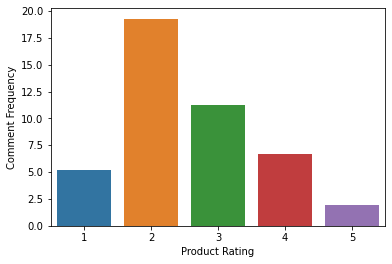

In [5]:
def average_number_of_comments(d):
    return df['Total_review_length'].count() / len(d)
average = df.groupby('review_score').apply(average_number_of_comments)
sns.barplot(
    average.index, 
    average.values, 
).set(xlabel='Product Rating', ylabel='Comment Frequency');

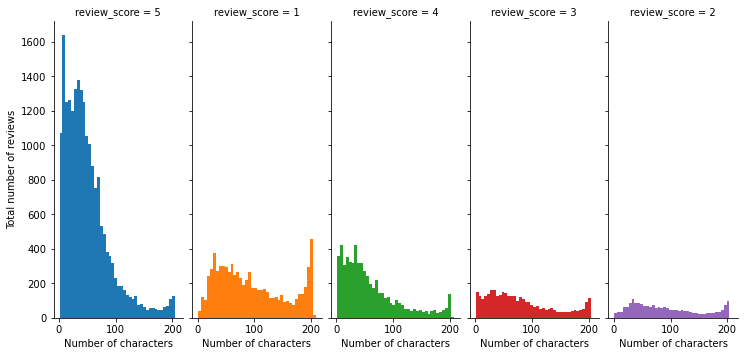

In [6]:
plot = sns.FacetGrid(data=df, col='review_score', hue='review_score')
plot.map(plt.hist, 'Total_review_length', bins=40)
plot.set_xlabels('Number of characters')
plot.set_ylabels('Total number of reviews')
plt.gcf().set_size_inches(10, 6)

In [7]:
review = ddf[['review_comment_message']].dropna()
review.head()

,review_comment_message
0,very good product
2,Meu produto não foi entregue até o momento!
3,"Produto bom, mas o pegador da tampa é de plást..."
4,"Produto igual ao anunciado, de excelente quali..."
5,Recebi antes do prazo e relógio é lindo


In [8]:
vec = TfidfVectorizer(max_features=100, ngram_range=(2, 4), stop_words=stopwords.words('portuguese'))
vec.fit(review['review_comment_message'])
trans = vec.transform(review['review_comment_message'])

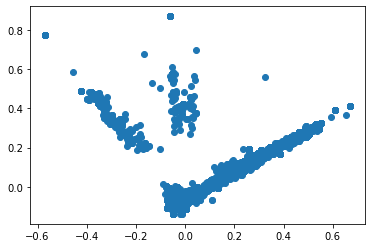

In [9]:
component_analysis = PCA(n_components=2, random_state=42)
component_analysis.fit(trans.toarray())
trans_component_analysis = component_analysis.transform(trans.toarray())
plt.scatter(trans_component_analysis[:,0], trans_component_analysis[:,1])

In [10]:
model = AgglomerativeClustering(n_clusters=2)
predicted = model.fit_predict(trans_component_analysis)


In [11]:
filename = 'finalized_model.sav'
joblib.dump(model, filename)

['finalized_model.sav']

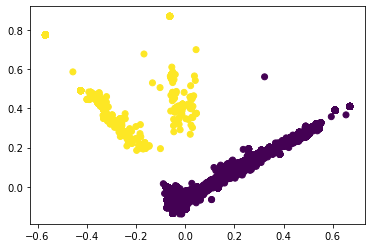

In [12]:
plt.scatter(trans_component_analysis[:, 0], trans_component_analysis[:, 1], c=predicted)

In [13]:
review['predicted'] = predicted

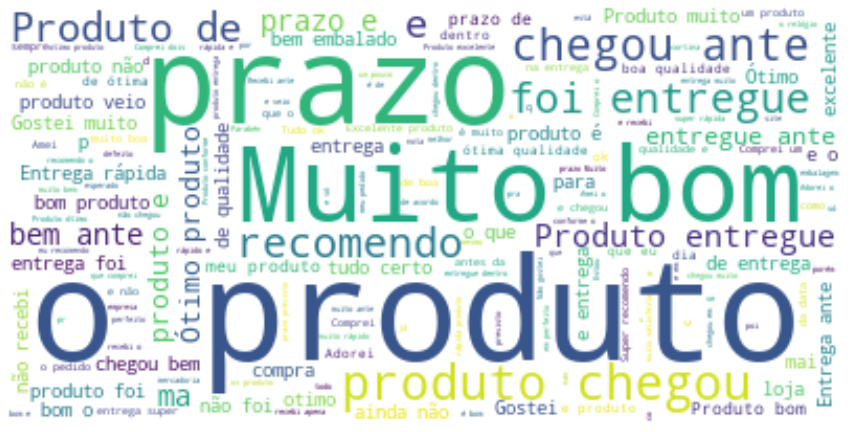

In [14]:
words = review[review['predicted'] == 0]['review_comment_message'].to_string()

cloud = WordCloud(background_color= 'white').generate(words)
plt.figure(figsize=(15, 15))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off");

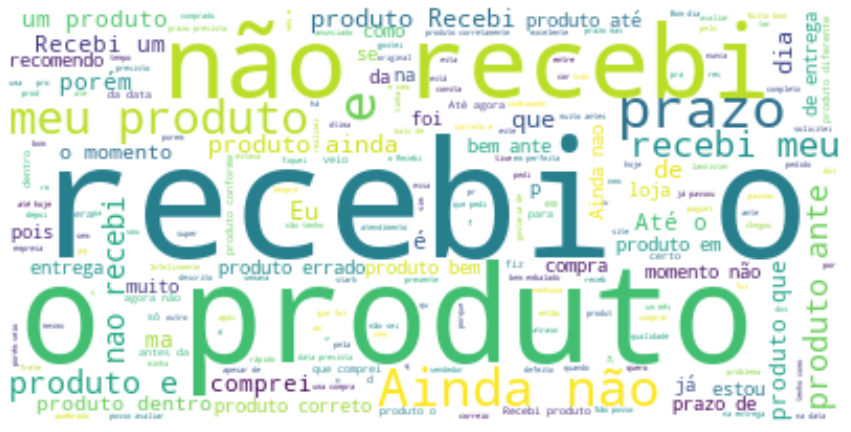

In [15]:
words = review[review['predicted'] == 1]['review_comment_message'].to_string()

cloud = WordCloud(background_color= 'white').generate(words)
plt.figure(figsize=(15, 15))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off");